In [1]:
import os
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import random

# importo los .py
import sys
sys.path.append("auxiliares")
import transformaciones
import config

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_producto_base.csv"

arch_min_max_prod = "datasets/emp3_min_max_prod.csv"
arch_mean_std_prod = "datasets/emp3_mean_std_prod.csv"

arch_salida = "datasets/emp3_sellout_producto_transf.csv"

In [4]:
def normalizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=config.TRAIN_PERIODO_LIMITE_PARAM) & (df_param.periodo >= config.PERIODO_INICIO_PARAM)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo min max por producto y lo guardo para poder revertir posteriormente
    df_min_max_prod = df_train.groupby('product_id')['tn'].agg(['max', 'min']).reset_index()
    df_min_max_prod = df_min_max_prod.rename(columns={"min":"valor_1","max":"valor_2"})
    df_min_max_prod.valor_1 = 0
    df_min_max_prod.to_csv(arch_min_max_prod, index=False)
        
    df_ret = df_param.merge(df_min_max_prod,how="left",on="product_id") #puede haber productos que no aparezcan, por eso left
    
    # Selecciono columnas a normalizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn

    # Transformo
    df_ret["tn"] =df_ret.apply(lambda row: transformaciones.normalizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
    df_ret["cust_request_tn"] =df_ret.apply(lambda row: transformaciones.normalizar_valor(row["cust_request_tn"],row["valor_1"],row["valor_2"]),axis=1)

    # Columna Control
    df_ret["tn_reconstruido"] =df_ret.apply(lambda row: transformaciones.desnormalizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)

    return df_ret

def estandarizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=config.TRAIN_PERIODO_LIMITE_PARAM) & (df_param.periodo >= config.PERIODO_INICIO_PARAM)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo media y desvio por producto y lo guardo para poder revertir posteriormente
    df_mean_std_prod = df_train.groupby('product_id')['tn'].agg(['mean', lambda x: np.std(x,ddof=0)]).reset_index() #se usa ddof=0 para evitar NaN cuando hay un solo producto
    df_mean_std_prod.columns = ["product_id",'valor_1', 'valor_2']
    df_mean_std_prod.to_csv(arch_mean_std_prod, index=False)
        
    df_ret = df_param.merge(df_mean_std_prod,how="left",on="product_id")
   
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn

    # Transformo
    df_ret["tn"] =df_ret.apply(lambda row: transformaciones.estandarizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
    df_ret["cust_request_tn"] =df_ret.apply(lambda row: transformaciones.estandarizar_valor(row["cust_request_tn"],row["valor_1"],row["valor_2"]),axis=1)

    # Columna de Control
    df_ret["tn_reconstruido"] =df_ret.apply(lambda row: transformaciones.desestandarizar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

############# AUXILIARES
def graficar_ejemplo_transformacion(df_param):
    product_id = np.array(df_param.sample(1).product_id)[0]
    df_param = df_param[df_param.product_id==product_id]
    
    plt.plot(df_param.tn_original)
    plt.title("Original - " + str(product_id))
    plt.show()
    
    plt.plot(df_param.tn)
    plt.title("Transformado - " + str(product_id))
    plt.show()

def transformar_df(tipo_transf, df_param):
    if tipo_transf == "normalizacion":
        print("Normalizacion")
        
        print(len(df_sellout))
        df_sellout_transf = normalizar_tn(df_sellout)
        print(len(df_sellout_transf))

    elif tipo_transf == "estandarizacion":
        print("Estandarizacion")
        
        print(len(df_sellout))
        df_sellout_transf = estandarizar_tn(df_sellout)
        print(len(df_sellout_transf))
        
    return df_sellout_transf

## Transformación

In [5]:
df_sellout = pd.read_csv(arch_entrada)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   product_id_tn              34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  float64
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  float64
 8   plan_precios_cuidados      34707 non-null  float64
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  flo

In [6]:
# Renombro tn
df_sellout = df_sellout.rename(columns={"product_id_tn":"tn"})

correlation = df_sellout.tn.corr(df_sellout.cust_request_tn)
print("Correlacion entre tn y cust_request_tn:", correlation)

Correlacion entre tn y cust_request_tn: 0.9994182345484015


--> es tan alta que las transformo con la misma escala

In [7]:
df_sellout_transf = transformar_df(config.TIPO_TRANSF_PARAM,df_sellout)

Estandarizacion
34707
34707


In [8]:
df_sellout_transf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34707 entries, 0 to 34706
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   tn                         34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  float64
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  float64
 8   plan_precios_cuidados      34707 non-null  float64
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  flo

In [9]:
# Control (puede haber un margen de error)
print(df_sellout_transf.tn_original.sum())
print(df_sellout_transf.tn_reconstruido.sum())

1299335.6272300002
1300169.0747999998


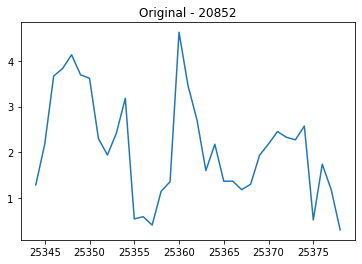

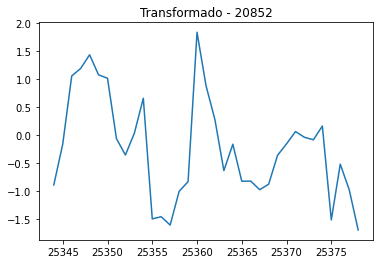

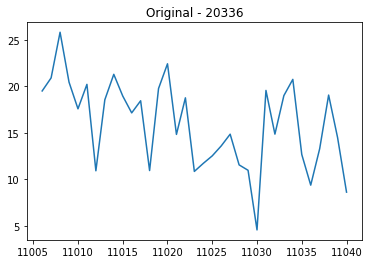

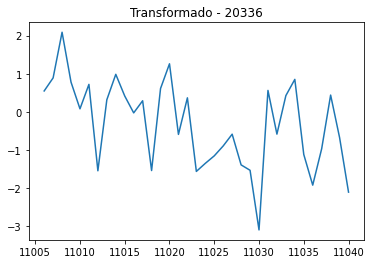

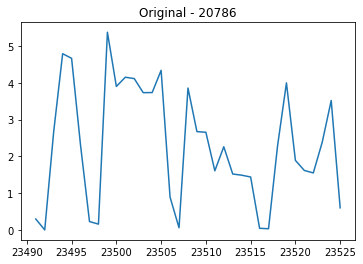

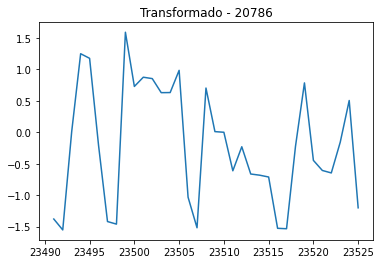

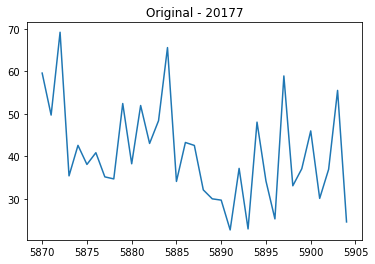

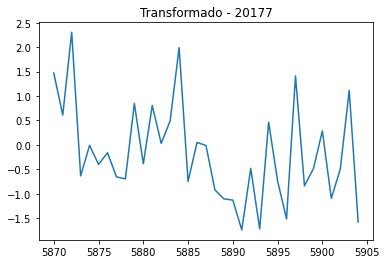

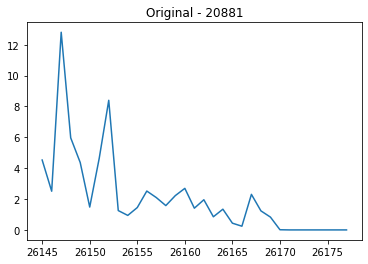

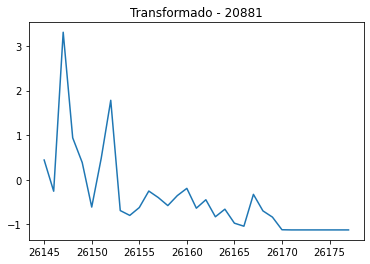

In [10]:
# Control visual de algunas series transformadas
for i in range(0,5):
    graficar_ejemplo_transformacion(df_sellout_transf)

In [11]:
# Se eliminar columnas de control (tn_mas_2_original la mantengo porque la uso para el error_rate durante validacion y testeo)
df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","tn_reconstruido","valor_1","valor_2"])

df_sellout_transf.to_csv(arch_salida,index=False)
len(df_sellout_transf)

34707

In [12]:
df_sellout_transf.columns

Index(['product_id', 'periodo', 'tn', 'cero_ventas', 'cust_request_qty',
       'cust_request_tn', 'mes', 'producto_estrella', 'plan_precios_cuidados',
       'meses_historia_prod', 'cat1', 'cat2', 'cat3', 'sku_size', 'temp_media',
       'temp_min_media', 'temp_max_media', 'IPC', 'promedio_mens_dolar_venta',
       'catastrofe'],
      dtype='object')

In [13]:
df_sellout_transf.isna().sum()

product_id                   0
periodo                      0
tn                           0
cero_ventas                  0
cust_request_qty             0
cust_request_tn              0
mes                          0
producto_estrella            0
plan_precios_cuidados        0
meses_historia_prod          0
cat1                         0
cat2                         0
cat3                         0
sku_size                     0
temp_media                   0
temp_min_media               0
temp_max_media               0
IPC                          0
promedio_mens_dolar_venta    0
catastrofe                   0
dtype: int64